幅広くデータを見ていく
* 加速度の波形を並べていみる
* ウィンドウフレームごとの平均，分散の変化

In [1]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [2]:
import numpy as np
from numpy import zeros, newaxis
import datetime
import os
import copy
import time

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Parametor about  " Sliding Window " 
WindowWidth =np.array([128,256,512,1024,2048,4096]) # Window Width
SlidingWidth =WindowWidth/4 #sliding window

# Parametor about Neural Network
AEDimention = 16

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"

#chopin
#StorePath = "/home/takeyama/Documents/"
#mozart
StorePath ="/media/takeyama/HD-PNFU3/01_ActivityResearchData/"
if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+DATE+'window/'): 
    os.makedirs(StorePath+TITLE+DATE+'window/')
WindowDataPath=StorePath+TITLE+DATE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+'/'+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+'/'+TITLE+DATE+'graph/')
GraphPath=StorePath+'/'+TITLE+DATE+'graph/'

センサデータの読み込み

In [3]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する

In [4]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [5]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [6]:
DictName=os.listdir(DictionaryDataPath)

In [7]:
Sensor1 = np.load(DictionaryDataPath+DictName[0])['data'][()]
Sensor2 = np.load(DictionaryDataPath+DictName[1])['data'][()]
Sensor3 = np.load(DictionaryDataPath+DictName[2])['data'][()]
Sensor4 = np.load(DictionaryDataPath+DictName[3])['data'][()]
Sensor5 = np.load(DictionaryDataPath+DictName[4])['data'][()]
Sensor6 = np.load(DictionaryDataPath+DictName[5])['data'][()]

グラフプロットする

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def MakingGraphPath(p):
    if not os.path.exists(GraphPath+p): 
        os.makedirs(GraphPath+p)
    ThisGraphPath=GraphPath+p
    return ThisGraphPath

まずは，すべてのセンサデータの加速度Ｘを並べて表示する

ウィンドウフレームごとのグラフ

  1%|          | 1061/134700 [00:00<00:12, 10592.94it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =134701
offset=6


100%|██████████| 134700/134700 [1:03:59<00:00, 16.89it/s]


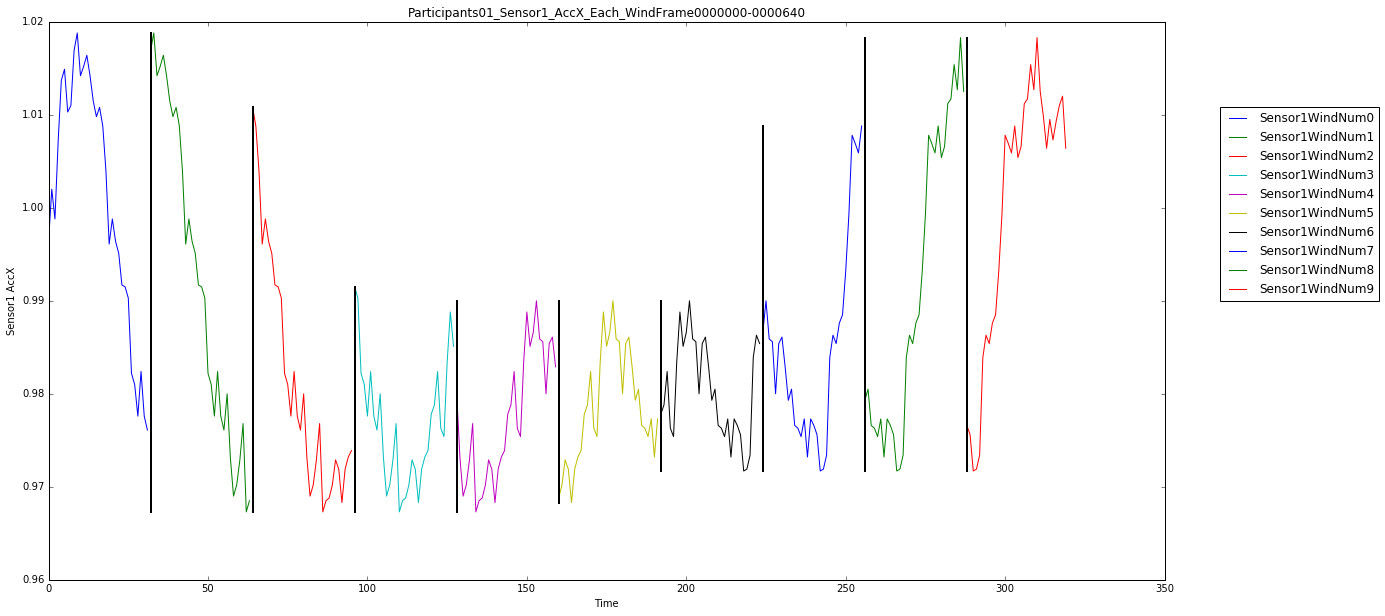

In [10]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.set_xlabel('Time')
ax.set_ylabel('AccX')

windowNum = 256
slidingNum = windowNum/32

w=window()
w.SetData('AccX',Sensor1['AccX'])
wind=w.Compile(windowWidth=windowNum, slidingWidth=slidingNum)

ThisGraphPath = MakingGraphPath('Sensor1/Wave_AccX_windowNum='+str(windowNum).zfill(4)\
                                +'_slidingNum='+str(windowNum).zfill(4)+'/')

RngPlotGraph = 10
for PltRng in tqdm_notebook( xrange(0,33683,32*RngPlotGraph)):
    for i in range(0,RngPlotGraph):
        MIN = wind[PltRng+i,:32].min()
        MAX = wind[PltRng+i,:32].max()
        ax.plot(range(i*32,(i+1)*32), wind[PltRng+i,:32],label='Sensor1'+'WindNum'+str(i))
        ax.plot([i*32, i*32], [MIN,MAX ], 'k-', lw=2)
    
    lgnd=ax.legend(bbox_to_anchor=(1.05, 0.5), loc='lower left', borderaxespad=0)

    ax.set_title("Participants01_Sensor1_AccX_Each_WindFrame"+str(PltRng).zfill(7)+\
                 '-'+str(PltRng+32*20).zfill(7))
    ax.set_ylabel("Sensor1 AccX")

    filename = "Participants01_Sensor1_AccX_Each_WindFrame"+str(PltRng).zfill(5)+\
    '-'+str(PltRng+32*50).zfill(5)+".png"
    ax.figure.savefig(ThisGraphPath+filename,bbox_extra_artists=(lgnd,), bbox_inches='tight')

    plt.show()
    
    ax.clear()
    time.sleep(0.01)

In [11]:
wind.shape

(134701, 256, 1)

In [12]:
Sensor1['AccX'].shape

(1077870,)

In [13]:
Sensor1['AccX'].size

1077870

In [14]:
Sensor1['AccX'].ndim

1

In [15]:
windowNum/32

8